## Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

This project aims to select the safest borough in London based on the **total crimes**, explore the **neighborhoods** of that borough to find the **10 most common venues** in each neighborhood and finally cluster the neighborhoods using **k-mean clustering**.

This report will be targeted to people who are looking to **relocate to London**. Inorder to finalise a neighborhood to hunt for an apartment, **safety** is considered as a top concern when moving to a new place. If you don’t feel safe in your own home, you’re not going to be able to enjoy living there. The **crime statistics** will provide an insight into this issue.

We will focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* The total number of crimes commited in each of the borough during the last year.
* The most common venues in each of the neighborhood in the safest borough selected.

Following data sources will be needed to extract/generate the required information:

- [**Part 1**: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016](#part1):  A dataset consisting of the crime statistics of each borough in London obtained from Kaggle
- [**Part 2**: Scraping additional information of the different Boroughs in London from a Wikipedia page.](#part2): More information regarding the boroughs of London is scraped using the Pandas library
- [**Part 3**: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.](#part3): Co-ordinate of neighborhood will be obtained using **Foursquare API**


### Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016<a name="part1"></a>


####  London Crime Data 

About this file

- lsoa_code: code for Lower Super Output Area in Greater London.
- borough: Common name for London borough.
- major_category: High level categorization of crime
- minor_category: Low level categorization of crime within major category.
- value: monthly reported count of categorical crime in given borough
- year: Year of reported counts, 2008-2016
- month: Month of reported counts, 1-12

Data set URL: https://www.kaggle.com/jboysen/london-crime


In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

import geocoder


from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import folium # plotting library

print('Folium installed')
print('Libraries imported.')


Folium installed
Libraries imported.


## Foursquare Credentials

In [99]:
CLIENT_ID = 'AOVORCJKESHFQPQ440X2QRVVSISKODUKMV2SBPKZ3WOGMHRK' # your Foursquare ID
CLIENT_SECRET = 'RVBS5I5YSY0BOWL003GW5VKEKAO12EZ0M4KO5IHCVWAAGSKF' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: AOVORCJKESHFQPQ440X2QRVVSISKODUKMV2SBPKZ3WOGMHRK
CLIENT_SECRET:RVBS5I5YSY0BOWL003GW5VKEKAO12EZ0M4KO5IHCVWAAGSKF


In [7]:
crime_df = pd.read_csv('london_crime_by_lsoa.csv')

In [8]:
crime_df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


### Since we are in 2020 so we will only use latest year data

In [10]:
crime_df.drop(crime_df.index[crime_df['year']!=2016],inplace=True)

In [11]:
crime_df

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
9,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
14,E01002398,Hillingdon,Theft and Handling,Theft/Taking Of Motor Vehicle,0,2016,2
...,...,...,...,...,...,...,...
13490538,E01003920,Southwark,Violence Against the Person,Harassment,5,2016,6
13490565,E01004742,Westminster,Theft and Handling,Theft/Taking of Pedal Cycle,0,2016,9
13490574,E01002823,Kensington and Chelsea,Theft and Handling,Motor Vehicle Interference & Tampering,0,2016,2
13490579,E01004100,Sutton,Drugs,Drug Trafficking,0,2016,12


In [12]:
crime_df = crime_df[crime_df.value!=0]

In [13]:
crime_df.reset_index(drop=True,inplace=True)

In [14]:
crime_df

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11
...,...,...,...,...,...,...,...
392037,E01001661,Greenwich,Violence Against the Person,Assault with Injury,2,2016,1
392038,E01002200,Harrow,Violence Against the Person,Common Assault,3,2016,3
392039,E01001862,Hammersmith and Fulham,Theft and Handling,Theft/Taking Of Motor Vehicle,2,2016,4
392040,E01003783,Redbridge,Drugs,Possession Of Drugs,5,2016,3


In [15]:
 crime_df['major_category'].value_counts()

Theft and Handling             129159
Violence Against the Person    123050
Criminal Damage                 48584
Burglary                        43020
Drugs                           21782
Robbery                         14889
Other Notifiable Offences       11558
Name: major_category, dtype: int64

In [17]:
london_crime = pd.pivot_table(crime_df,values=['value'],
                             index=['borough'],
                             columns=['major_category'],
                             aggfunc=np.sum,
                             fill_value=0)

In [19]:
london_crime.head()

value                                                  \
major_category       Burglary Criminal Damage Drugs Other Notifiable Offences   
borough                                                                         
Barking and Dagenham     1287            1949   919                       378   
Barnet                   3402            2183   906                       499   
Bexley                   1123            1673   646                       294   
Brent                    2631            2280  2096                       536   
Bromley                  2214            2202   728                       417   

                                                                             
major_category       Robbery Theft and Handling Violence Against the Person  
borough                                                                      
Barking and Dagenham     534               5607                        6067  
Barnet                   464               9731                        7499  
Bexley                   209               4392                        4503  
Brent                    919               9026                        9205  
Bromley                  369               7584                        6650

In [22]:
london_crime.reset_index(inplace=True)

In [23]:
london_crime['Total'] = london_crime.sum(axis=1)
london_crime.head()

borough    value                        \
major_category                       Burglary Criminal Damage Drugs   
0               Barking and Dagenham     1287            1949   919   
1                             Barnet     3402            2183   906   
2                             Bexley     1123            1673   646   
3                              Brent     2631            2280  2096   
4                            Bromley     2214            2202   728   

                                                                     \
major_category Other Notifiable Offences Robbery Theft and Handling   
0                                    378     534               5607   
1                                    499     464               9731   
2                                    294     209               4392   
3                                    536     919               9026   
4                                    417     369               7584   

                                            Total  
major_category Violence Against the Person         
0                                     6067  16741  
1                                     7499  24684  
2                                     4503  12840  
3                                     9205  26693  
4                                     6650  20164

In [24]:
london_crime.columns = london_crime.columns.map(''.join)
london_crime.head()

,borough,valueBurglary,valueCriminal Damage,valueDrugs,valueOther Notifiable Offences,valueRobbery,valueTheft and Handling,valueViolence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


In [25]:
london_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
london_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


## Scrapping different boroughs in london from wikipedia page.
link='https://en.wikipedia.org/wiki/List_of_London_boroughs'

In [26]:
url='https://en.wikipedia.org/wiki/List_of_London_boroughs'
panda = pd.read_html(url)

In [40]:
London_table = panda[0]

In [44]:
London_table_1=panda[1]

In [55]:
London_table=Londan_table.append(London_table_1,ignore_index=True,sort=True)

In [56]:
London_table.shape

(33, 12)

In [57]:
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 
London_table.head()

,Area (sq mi),Borough,Co-ordinates,Headquarters,Inner,Local authority,Nr. in map,Nr. inmap,Political control,Population (2013 est)[1],Population(2011 est),Status
0,13.93,Barking and Dagenham [],51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,"Town Hall, 1 Town Square",NaN,Barking and Dagenham London Borough Council,25.0,NaN,Labour,194352.0,NaN,NaN
1,33.49,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,"North London Business Park, Oakleigh Road South",NaN,Barnet London Borough Council,31.0,NaN,Conservative,369088.0,NaN,NaN
2,23.38,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,"Civic Offices, 2 Watling Street",NaN,Bexley London Borough Council,23.0,NaN,Conservative,236687.0,NaN,NaN
3,16.70,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,"Brent Civic Centre, Engineers Way",NaN,Brent London Borough Council,12.0,NaN,Labour,317264.0,NaN,NaN
4,57.97,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,"Civic Centre, Stockwell Close",NaN,Bromley London Borough Council,20.0,NaN,Conservative,317899.0,NaN,NaN


In [58]:
London_table.iloc[0,1] = 'Barking and Dagenham'
London_table.iloc[9,1] = 'Greenwich'
London_table.iloc[11,1] = 'Hammersmith and Fulham'

In [59]:
London_table.head()

,Area (sq mi),Borough,Co-ordinates,Headquarters,Inner,Local authority,Nr. in map,Nr. inmap,Political control,Population (2013 est)[1],Population(2011 est),Status
0,13.93,Barking and Dagenham,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,"Town Hall, 1 Town Square",NaN,Barking and Dagenham London Borough Council,25.0,NaN,Labour,194352.0,NaN,NaN
1,33.49,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,"North London Business Park, Oakleigh Road South",NaN,Barnet London Borough Council,31.0,NaN,Conservative,369088.0,NaN,NaN
2,23.38,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,"Civic Offices, 2 Watling Street",NaN,Bexley London Borough Council,23.0,NaN,Conservative,236687.0,NaN,NaN
3,16.70,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,"Brent Civic Centre, Engineers Way",NaN,Brent London Borough Council,12.0,NaN,Labour,317264.0,NaN,NaN
4,57.97,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,"Civic Centre, Stockwell Close",NaN,Bromley London Borough Council,20.0,NaN,Conservative,317899.0,NaN,NaN


In [52]:
Ld_crime = pd.merge(london_crime, London_table, on='Borough')
Ld_crime.head(10)


,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Area (sq mi),Co-ordinates,Headquarters,Inner,Local authority,Nr. in map,Nr. inmap,Political control,Population (2013 est)[1],Population(2011 est),Status
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741,13.93,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,"Town Hall, 1 Town Square",NaN,Barking and Dagenham London Borough Council,25.0,NaN,Labour,194352.0,NaN,NaN
1,Barnet,3402,2183,906,499,464,9731,7499,24684,33.49,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,"North London Business Park, Oakleigh Road South",NaN,Barnet London Borough Council,31.0,NaN,Conservative,369088.0,NaN,NaN
2,Bexley,1123,1673,646,294,209,4392,4503,12840,23.38,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,"Civic Offices, 2 Watling Street",NaN,Bexley London Borough Council,23.0,NaN,Conservative,236687.0,NaN,NaN
3,Brent,2631,2280,2096,536,919,9026,9205,26693,16.70,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,"Brent Civic Centre, Engineers Way",NaN,Brent London Borough Council,12.0,NaN,Labour,317264.0,NaN,NaN
4,Bromley,2214,2202,728,417,369,7584,6650,20164,57.97,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,"Civic Centre, Stockwell Close",NaN,Bromley London Borough Council,20.0,NaN,Conservative,317899.0,NaN,NaN
5,Camden,2652,1935,1493,490,899,14088,7626,29183,8.40,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,"Camden Town Hall, Judd Street",NaN,Camden London Borough Council,11.0,NaN,Labour,229719.0,NaN,NaN
6,City of London,2,2,10,6,4,129,25,178,1.12,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,Guildhall,([],Corporation of London;Inner Temple;Middle Temple,NaN,1.0,?,NaN,7000.0,Sui generis;City;Ceremonial county
7,Croydon,2738,3219,1367,718,1139,9229,10302,28712,33.41,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,"Bernard Weatherill House, Mint Walk",NaN,Croydon London Borough Council,19.0,NaN,Labour,372752.0,NaN,NaN
8,Ealing,2492,2562,1355,613,669,10040,9396,27127,21.44,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,"Perceval House, 14-16 Uxbridge Road",NaN,Ealing London Borough Council,13.0,NaN,Labour,342494.0,NaN,NaN
9,Enfield,2541,2136,1063,492,807,8037,7409,22485,31.74,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,"Civic Centre, Silver Street",NaN,Enfield London Borough Council,30.0,NaN,Labour,320524.0,NaN,NaN


In [63]:
Ld_crime.drop(['Nr. inmap','Population(2011 est)'],axis=1,inplace=True)

In [64]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352.0,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,1287,1949,919,378,534,5607,6067,16741
1,Barnet,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,3402,2183,906,499,464,9731,7499,24684
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1123,1673,646,294,209,4392,4503,12840
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,2214,2202,728,417,369,7584,6650,20164


## Methodology

The methodology in this project consists of two parts:
- [Exploratory Data Analysis](#EDA): Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.


- [Modelling](#modelling): To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.
 

In [68]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [67]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841.0,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,3218,2179,2049,708,1822,27520,10834,48330
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242.0,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,3087,2764,2738,635,1196,13155,10496,34071
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464.0,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,2946,2621,1838,494,1317,12946,9474,31636
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227.0,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,2115,2496,1684,713,1472,11964,9646,30090
29,Tower Hamlets,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890.0,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,2794,2357,1629,678,1234,10953,9608,29253


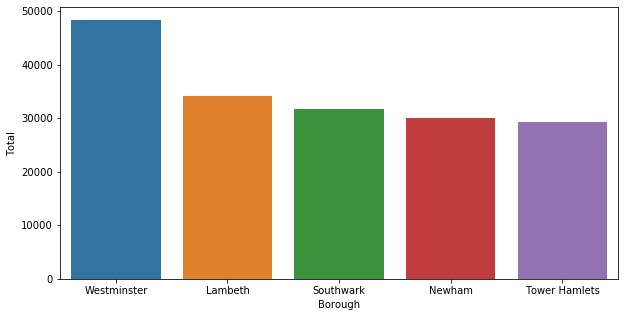

In [74]:
plt.figure(figsize=(10,5))
sns.barplot(x='Borough' , y='Total',data=df_top5)


In [75]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,NaN,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,2,2,10,6,4,129,25,178
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793.0,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,879,1054,743,189,121,3803,3194,9983
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914.0,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,1233,1316,461,253,165,3516,3714,10658
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365.0,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,1359,1148,320,217,106,4769,3155,11074
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223.0,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,1419,1418,466,249,283,4894,4026,12755


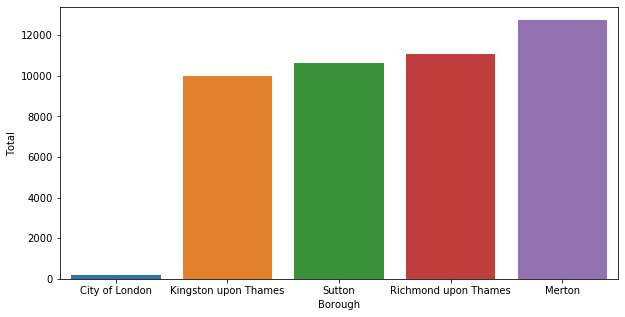

In [76]:
plt.figure(figsize=(10,5))
sns.barplot(x='Borough' , y='Total',data=df_bot5)


### As per wikipidea city of london is not a borough so Kingston upon thames is safest place to look around

In [77]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


In [80]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [81]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


In [122]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


In [123]:
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

### Modelling <a name="modelling"></a>

- Finding all the venues within a 500 meter radius of each neighborhood.
- Perform one hot ecoding on the venues data.
- Grouping the venues by the neighborhood and calculating their mean.
- Performing a K-means clustering (Defining K = 5)

In [106]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [107]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )


Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [108]:
print(kut_venues.shape)
kut_venues.head()

(174, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Berrylands,51.393781,-0.284802,La Monaliza,51.389936,-0.283165,Colombian Restaurant
4,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park


In [109]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,4,4,4,4,4,4
Canbury,14,14,14,14,14,14
Chessington,1,1,1,1,1,1
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,8,8,8,8,8,8


In [110]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 71 uniques categories.


In [111]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.071429,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Chessington,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hook,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kingston upon Thames,0.033333,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.033333,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.000000
6,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,New Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Norbiton,0.000000,0.035714,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.035714,0.035714,0.000000,0.000000,0.035714,0.000000,0.000000,0.035714


In [113]:
kut_grouped.shape

(14, 72)

In [114]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0  Gym / Fitness Center  0.25
1  Colombian Restaurant  0.25
2                  Park  0.25
3              Bus Stop  0.25
4      Asian Restaurant  0.00


----Canbury----
               venue  freq
0                Pub  0.29
1              Plaza  0.07
2        Supermarket  0.07
3               Park  0.07
4  Fish & Chips Shop  0.07


----Chessington----
                        venue  freq
0  Construction & Landscaping   1.0
1                 Golf Course   0.0
2                 Pizza Place   0.0
3                    Pharmacy   0.0
4                    Pet Café   0.0


----Hook----
               venue  freq
0  Fish & Chips Shop  0.25
1             Bakery  0.25
2  Indian Restaurant  0.25
3        Supermarket  0.25
4   Asian Restaurant  0.00


----Kingston Vale----
            venue  freq
0   Grocery Store  0.25
1    Soccer Field  0.25
2             Bar  0.25
3  Sandwich Place  0.25
4        Pet Café  0.00


----Kingston upon Thames----
       

In [115]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [116]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Colombian Restaurant,Park,Gym / Fitness Center,Bus Stop,Electronics Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Farmers Market
1,Canbury,Pub,Park,Fish & Chips Shop,Indian Restaurant,Supermarket,Spa,Café,Shop & Service,Hotel,Plaza
2,Chessington,Construction & Landscaping,Farmers Market,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Wine Shop,Colombian Restaurant
3,Hook,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,Wine Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store
4,Kingston Vale,Grocery Store,Bar,Soccer Field,Sandwich Place,Wine Shop,Farmers Market,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store


In [117]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 2, 1, 0, 1, 3, 4, 1, 1])

In [118]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,4.0,Colombian Restaurant,Park,Gym / Fitness Center,Bus Stop,Electronics Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Farmers Market
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1.0,Pub,Park,Fish & Chips Shop,Indian Restaurant,Supermarket,Spa,Café,Shop & Service,Hotel,Plaza
2,Chessington,Kingston upon Thames,51.358336,-0.298622,2.0,Construction & Landscaping,Farmers Market,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Wine Shop,Colombian Restaurant
3,Coombe,Kingston upon Thames,51.419450,-0.265398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hook,Kingston upon Thames,51.367898,-0.307145,1.0,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,Wine Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store


In [119]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [120]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [125]:
from matplotlib.pyplot import cm

In [126]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

From above map we can see that there are 5 types of clusters formed.
<li>Purple -> 1</li>
<li>Orange->4</li>
<li>Red->0</li>
<li>Blue->4</li>
<li>Green->3</li>



## Analysis <a name="analysis"></a>

Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

In [127]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.43185,-0.258138,0,Grocery Store,Bar,Soccer Field,Sandwich Place,Wine Shop,Farmers Market,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store


In [128]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1,Pub,Park,Fish & Chips Shop,Indian Restaurant,Supermarket,Spa,Café,Shop & Service,Hotel,Plaza
4,Hook,Kingston upon Thames,51.367898,-0.307145,1,Indian Restaurant,Bakery,Supermarket,Fish & Chips Shop,Wine Shop,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,1,Coffee Shop,Café,Pub,Sushi Restaurant,Burger Joint,Department Store,German Restaurant,Furniture / Home Store,French Restaurant,Electronics Store
9,New Malden,Kingston upon Thames,51.405335,-0.263407,1,Korean Restaurant,Gastropub,Chinese Restaurant,Sushi Restaurant,Supermarket,Gym,Indian Restaurant,Discount Store,Cosmetics Shop,Deli / Bodega
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,1,Indian Restaurant,Food,Pub,Italian Restaurant,Platform,Farmers Market,Fried Chicken Joint,Coffee Shop,Hardware Store,Hotel
11,Old Malden,Kingston upon Thames,51.382484,-0.259090,1,Train Station,Food,Child Care Service,Pub,Construction & Landscaping,French Restaurant,Fried Chicken Joint,Fish & Chips Shop,Fast Food Restaurant,Colombian Restaurant
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,1,Indian Restaurant,Coffee Shop,Café,Pub,Pet Café,Fish & Chips Shop,Fast Food Restaurant,Golf Course,Chinese Restaurant,Gym
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,1,Coffee Shop,Pub,Italian Restaurant,Pharmacy,Grocery Store,Gastropub,Hotel,Deli / Bodega,Gym / Fitness Center,Pizza Place
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,1,Grocery Store,Restaurant,Sandwich Place,Coffee Shop,Indian Restaurant,Hotel,Pharmacy,Pizza Place,Café,Bus Stop


In [129]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Chessington,Kingston upon Thames,51.358336,-0.298622,2,Construction & Landscaping,Farmers Market,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Wine Shop,Colombian Restaurant


In [130]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,3,Garden Center,Convenience Store,Pub,Restaurant,Discount Store,Construction & Landscaping,Cosmetics Shop,Deli / Bodega,Department Store,Electronics Store


In [131]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,4,Colombian Restaurant,Park,Gym / Fitness Center,Bus Stop,Electronics Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Farmers Market
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,4,Park,Gym,Bus Stop,Soccer Field,Electronics Store,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store


## Results and Discussion
The aim of this project is to help people find the safe place in london where they can facilities as per their requirement.
We can see that most of the Venues are covered in Cluster 1 so it would be the perfect place to look at but it will be crowdy.
So, as per the requirements and budget people can choose 

# Colclusion
This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood.
Using Data Analysis and machine learning to help people in making their decision. We have not included cost of living so future of this project will be to include it and then short list based of safety and budget.